**VGG16 model to detect COVID-19 using Chest x-ray images.**

**Exploratory Data Analysis**

I will be using the VGG16 model to detect Chest x-ray images that match with Chest x-ray images COVID-19. 

List of classes of chest X-ray images given in the dataset

* Normal pneumonia.
* COVID-19.
* Viral pneumonia chest.
* Lung Opacity (Non-COVID lung infection).

VGG16 is a convolutional neural network that is 16 layers deep. VGG16 has convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture.
In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.
![image.png](attachment:90054c23-c13a-4048-aa20-93159f32fdf0.png)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()
path=%cd /content/drive/My Drive/covid_detect

/content/drive/My Drive/covid_detect


In [4]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns

# Explore Data Analysis

In [9]:
path_normal = '/content/drive/My Drive/covid_detect/Covid19-dataset_2/Normal'
path_covid = '/content/drive/My Drive/covid_detect/Covid19-dataset_2/COVID'
path_lung_opacity = '/content/drive/My Drive/covid_detect/Covid19-dataset_2/Lung_Opacity'
path_viral_pneumonia = '/content/drive/My Drive/covid_detect/Covid19-dataset_2/Viral Pneumonia'

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_lung_opacity =  len(os.listdir(path_lung_opacity))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))

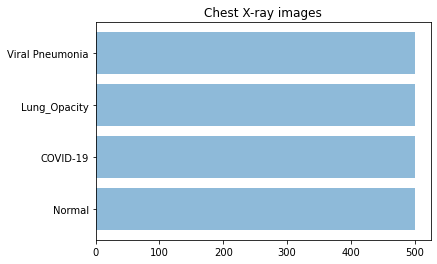

In [10]:
objects = ('Normal', 'COVID-19','Lung_Opacity','Viral Pneumonia')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid,len_lung_opacity,len_viral_pneumonia]

plt.barh(y_pos,performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.title('Chest X-ray images')

plt.show()

**Overview Chest X-ray images**

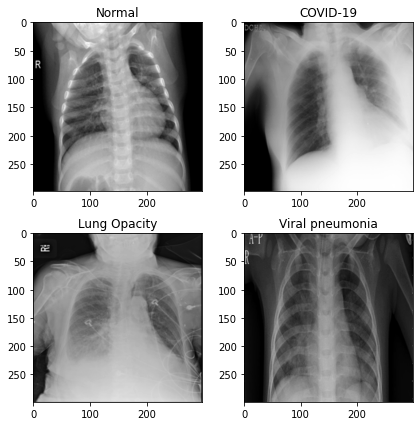

In [18]:
labels = ['Normal', 'COVID-19','Lung Opacity', 'Viral pneumonia']
img1 = path_normal+"/Normal-500.png"
img2 = path_covid+"/COVID-500.png"
img3 = path_lung_opacity+"/Lung_Opacity-500.png"
img4 = path_viral_pneumonia + "/Viral Pneumonia-500.png"

imgs = [img1, img2,img3,img4]

fig, ax = plt.subplots(2,2 , figsize=(6, 6))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

**Load data**

In [19]:
from PIL import Image, ImageOps
def resize_image(imgpath):
    img = np.array(ImageOps.grayscale(Image.open(imgpath)).resize((150, 150), Image.ANTIALIAS))
    return img

In [20]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
for i in os.listdir(path_lung_opacity):
    try:
        imgpath = path_lung_opacity+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(2)
    except:
        None
for i in os.listdir(path_viral_pneumonia):
    try:
        imgpath = path_viral_pneumonia+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(3)
    except:
        None
x_ = np.array(x_)

**Model Clases**

# Split test, train, validation data

In [21]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.15,random_state = 40)

**Clases: Normal, COVID-19, Lung Opacity, Viral pneumonia**

In [22]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y,num_classes = 4)

classNames = ["normal","COVID_19", "lung_opacity","viral_pneumonia"]
print(classNames)

['normal', 'COVID_19', 'lung_opacity', 'viral_pneumonia']


In [ ]:
unique, counts = np.unique(y_train.argmax(axis=1), return_counts=True)
uniqueVal, countsVal = np.unique(y_val.argmax(axis=1), return_counts=True)
dict(zip(unique, counts))

In [24]:
dict(zip(uniqueVal, countsVal))

NameError: ignored

# Build VGG16 model

In [27]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
def createModel():
    _input = Input(shape=(150,150,1))

    conv1  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(_input)
    conv2  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1  = MaxPooling2D((2, 2))(conv2)
    

    conv3  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    conv4  = BatchNormalization()(conv4)
    pool2  = MaxPooling2D((2, 2))(conv4)

    conv5  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv6  = BatchNormalization()(conv6)
    pool3  = MaxPooling2D((2, 2))(conv6)

    conv7  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv8  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv7)
    conv8 = BatchNormalization()(conv8)
    pool4  = MaxPooling2D((2, 2))(conv8)
    pool4 = Dropout(rate=0.2)(pool4)
    
    conv9 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv10 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    conv10 = BatchNormalization()(conv10)
    pool5  = MaxPooling2D((2, 2))(conv10)
    pool5 = Dropout(rate=0.2)(pool5)

    flat   = Flatten()(pool5)
    dense1 = Dense(512, activation="relu")(flat)   
    dropout1 = Dropout(rate=0.7)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output = Dense(4, activation="sigmoid")(dropout2)
    model  = Model(inputs=_input, outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

**We are going to run with the above model**

In [28]:
modelFitLRate = createModel()
epochs = 10
history = modelFitLRate.fit(x_train, y_train, validation_data=(x_val, y_val),
                            batch_size=32, epochs=epochs)

ValueError: ignored

In [ ]:
def showChartEpochAccuracy(history):
    # show a nicely formatted classification report
    print("[INFO] evaluating network...")
    # plot the training loss and accuracy
    N = epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy Dataset")
    plt.xlabel("Epochs #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

showChartEpochAccuracy(history)

**Hyper parameters**

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

epochs = 10
learning_rate = 0.0001
decay_rate = 5e-6

model = createModel()

adam = Adam(lr=learning_rate,decay=decay_rate)
sgd = SGD(lr=0.0001, momentum=0.9, decay=decay_rate)
model.compile(loss='mean_squared_error',optimizer=adam,metrics=['mean_absolute_error','accuracy'])

def step_decay(losses):
    i = float(2*np.sqrt(np.array(history.losses[-1])))

    if i <0.6:
        lrate=0.001*1/(1+0.7*len(history.losses))
        decay_rate=2e-6
    else:
        lrate =0.0001
   
    return lrate
history=LossHistory()
lrate=LearningRateScheduler(step_decay)

myhistory = model.fit(x_train,y_train,validation_data=
                      (x_val, y_val),batch_size=64, 
                      epochs=epochs,callbacks=[history,lrate], verbose=1)

In [ ]:
showChartEpochAccuracy(myhistory)

# Test and Evaluate Model

**Predict with test data**

In [ ]:
# Get predictions
mypredict = model.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)

In [ ]:
evalute = model.evaluate(x_test, y_test)

In [ ]:
print("Accuracy: {:.2f}%".format(evalute[2] * 100))  
print("Loss: {}".format(evalute[0])) 

# Confusion matrix

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

In [ ]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


cm = confusion_matrix(y_test.argmax(axis=1), mypredict.argmax(axis=1))

plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrix",fontsize=24)
plt.title("Covid Detection with VGG-16 Confusion Matrix")
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()



In [ ]:
print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), mypredict.argmax(axis=1)) )
print ('Report : ')
print (classification_report(y_test.argmax(axis=1), mypredict.argmax(axis=1)) )

**Visualization Learning Rate**

In [ ]:
print('Learning Rate', sd)

In [ ]:
def showChartLearningRate(history):
    print("[INFO] evaluating network...")
    # plot the training loss and accuracy
    N = epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["mean_absolute_error"], label="train_mean_absolute_error")
    plt.plot(np.arange(0, N), history.history["val_mean_absolute_error"], label="val_mean_absolute_error")
    plt.title("Training Loss and mean absolute error on Dataset")
    plt.xlabel("Epochs #")
    plt.ylabel("Loss/Mean_absolute_error")
    plt.legend(loc="lower left")
    plt.show()
showChartLearningRate(myhistory)

# Show Result Prediction

if predicted label is equal to real label we can see the text and bar in blue.
if predicted label is not equal to real label we can see the text and bar in red.

In [ ]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = cv2.resize(img,(128,128))
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label= np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)
    
def showResultPrediction(predictions):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, y_test, x_test)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, y_test)
    plt.show()

showResultPrediction(mypredict)

**References:**

https://github.com/abhinavsagar/kaggle-notebooks/blob/master/Chest_X-Ray.ipynb
https://www.kaggle.com/code/robikscube/eda-lets-detect-pneumonia-explore-lung-images
https://www.kaggle.com/code/malekmavetgaming/diagnosing-pneumonia-with-your-convnet-ional-dr#build
https://www.sciencedirect.com/science/article/pii/S2666285X21000558                               
https://neurohive.io/en/popular-networks/vgg16/